In [1]:
### Importing required libraries
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout

In [5]:
path = 'Dataset'
CATEGORIES = os.listdir(path)
labels = [i for i in range(len(CATEGORIES))]
label_dict = dict(zip(CATEGORIES, labels))

In [6]:
print(label_dict)
print(CATEGORIES)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [7]:
img_size = 100
data = []
target = []

In [8]:
for category in CATEGORIES:
    fold_path = os.path.join(path, category)
    img_names = os.listdir(fold_path)
    
    for img_name in img_names:
        img_path = os.path.join(fold_path, img_name)
        img = cv2.imread(img_path)
        
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            
            data.append(resized)
            target.append(label_dict[category])
            
        except Exception as e:
            print('Exception:', e)

In [12]:
data = np.array(data)/255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)

new_target = np_utils.to_categorical(target)

In [13]:
np.save('data', data)
np.save('target', new_target)

# Training the CNN

In [14]:
### Loading save data and target files
data = np.load('data.npy')
target = np.load('target.npy')

In [17]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.callbacks import ModelCheckpoint

model = Sequential()

### First CNN layer follows the Relu and MaxPooling layers
model.add(Conv2D(200, (3,3), input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

### Second CNN layer follow the Relu and MaxPooling layers
model.add(Conv2D(100, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

### Flatten the layer to stack the output
model.add(Flatten())
model.add(Dropout(0.5))

### Dense layer
model.add(Dense(50, activation='relu'))

### Final layer with two neurons
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [19]:
### Splitting dataset into train test sets
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.1)

In [20]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor='val-loss', verbose=0, save_best_only=True, mode='auto')
hist = model.fit(data_train, target_train, epochs=20, callbacks=[checkpoint], validation_split=0.2)

Epoch 1/20
31/31 [==============================] - 32s 1s/step - loss: 0.7211 - accuracy: 0.5141 - val_loss: 0.6880 - val_accuracy: 0.5363
Epoch 2/20
31/31 [==============================] - 34s 1s/step - loss: 0.6465 - accuracy: 0.6424 - val_loss: 0.5461 - val_accuracy: 0.7540
Epoch 3/20
31/31 [==============================] - 32s 1s/step - loss: 0.4719 - accuracy: 0.7919 - val_loss: 0.4562 - val_accuracy: 0.8226
Epoch 4/20
31/31 [==============================] - 32s 1s/step - loss: 0.3635 - accuracy: 0.8384 - val_loss: 0.3768 - val_accuracy: 0.8347
Epoch 5/20
31/31 [==============================] - 32s 1s/step - loss: 0.2635 - accuracy: 0.9051 - val_loss: 0.2783 - val_accuracy: 0.8992
Epoch 6/20
31/31 [==============================] - 33s 1s/step - loss: 0.1877 - accuracy: 0.9323 - val_loss: 0.3431 - val_accuracy: 0.8710
Epoch 7/20
31/31 [==============================] - 33s 1s/step - loss: 0.1478 - accuracy: 0.9455 - val_loss: 0.2110 - val_accuracy: 0.9315
Epoch 8/20
31/31 [==

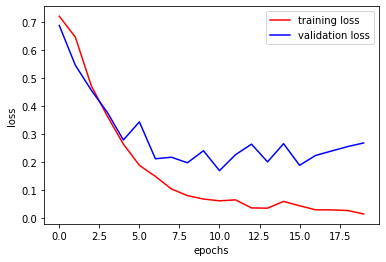

In [25]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], 'r', label='training loss')
plt.plot(hist.history['val_loss'], 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

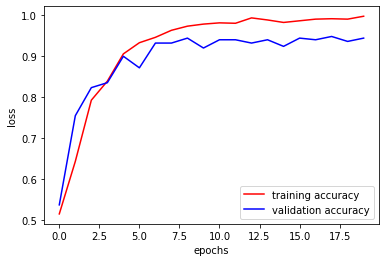

In [24]:
plt.plot(hist.history['accuracy'], 'r', label='training accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [30]:
print(model.evaluate(data_test, target_test))

5/5 [==============================] - 1s 181ms/step - loss: 0.0968 - accuracy: 0.9783
[0.09681364893913269, 0.97826087474823]


# Detecting faces with and without mask

In [33]:
model = load_model('model-020.model')   ### Selecting the best trained model

face_clsfr = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

src = cv2.VideoCapture(2)

labels_dict = {0:'Mask', 1:'No Mask'}
color_dict = {0:(0,0,255), 1:(255,0,0)}

In [ ]:
while(True):
    ret,img = src.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray,1.3,5)
    
    for x,y,w,h in faces:
        face_img = gray[y:y+w, x:x+h]
        resized = cv2.resize(face_img, (100,100))
        normalized = resized/255.0
        reshaped = np.reshape(normalized, (1,100,100,1))
        result = model.predict(reshaped)
        
        label = np.argmax(result, axis=1)[0]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), color_dict[label], 2)
        cv2.rectangle(img, (x,y-40), (x+w,y), color_dict[label], -1)
        cv2.putText(img, labels_dict[label], (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        
    cv2.imshow('LIVE',img)
    key = cv2.waitKey(1)
    
    if(key == 27):
        break
        
cv2.destroyAllWindows()
src.release()